# Model One - DenseNet
We will now be taking our **Spectrograms** that have been labeled and segmented into: *trash/fire* and building a Learning Algorithm on top of that. 

We will be using **FastAI's** Deep Learning Framework which is built on top of the **PyTorch**. You can check out more about this amazing framework here: https://www.fast.ai/ 

This notebook is ran on **Paperspace** *gradient machine*. If you do not have a good local GPU, I would highly suggest running this notebook in a **GPU** of your choice. https://colab.research.google.com/ (free)

Given this notebook isn't ran locally, we will do a simple git pull to the entire repository and continue out work:
https://github.com/dmbernaal/SpectrogramAI 

### DenseNet
From previous experiments, we will first attempt using a **DenseNet** Architecture (pre-trained). Generally this Architecture performs well on this type of data. We will later experiment with others including a **WideResNet** and many more. 

Initially we will train with **FastAI's** given parameter settings, and will later **fine-tune** our model if there seems to be promise.

We want to initially determine if our *hypothesis* holds true. That is, we can build a **CNN** to extract and find patterns from songs that are currently popular, and those which aren't. 

In [1]:
import torch
from torchvision.models import *
from fastai.vision import *

import pandas as pd
import numpy as np
import os

In [ ]:
# !pip install fastai

In [6]:
# change these to your settings
!git config --global user.email = "dmbernaal@gmail.com"
!git config --global user.name = "Diego Medina-Bernal"

In [11]:
!git clone https://github.com/dmbernaal/SpectrogramAI.git

Cloning into 'SpectrogramAI'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 109 (delta 3), reused 108 (delta 2), pack-reused 0
Receiving objects: 100% (109/109), 57.70 MiB | 17.96 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking connectivity... done.


In [2]:
# creating a FastAI path object
images_path = './SpectrogramAI/spectrograms/'
path = Path(images_path)
path.ls()

[PosixPath('SpectrogramAI/spectrograms/trash'),
 PosixPath('SpectrogramAI/spectrograms/models'),
 PosixPath('SpectrogramAI/spectrograms/fire')]

## Test 1. No Data augmentation & pre-set parameters
For our first test we will just build a simple pre-trained DenseNet applying no data augmentation to our data

In [5]:
# Data Augmentation
tfms_ = get_transforms(do_flip=False, flip_vert=False, max_rotate=0.0, max_zoom=0.0, max_lighting=0.0, max_warp=0.0)

# Source object
seed = np.random.seed(42)
src = (ImageItemList.from_folder(path)
                     .random_split_by_pct(.20, seed)
                     .label_from_folder())

# Creating Data object function
def get_data(image_size, batch_size):
    data = (src.transform(tfms=tfms_, size=image_size)
               .databunch(num_workers=2, bs=batch_size).normalize(imagenet_stats))
    return data

In [6]:
# Creating our data object
# 1368 × 864
# print(1368/2) # 684
# print(864/2) # 432
data = get_data((432, 684), 4)
# data = get_data((864, 1368), 4)

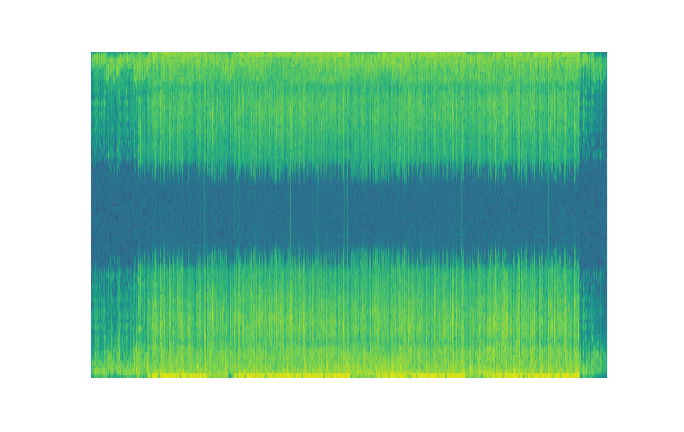

In [5]:
ds = data.train_ds
img,label = ds[0]
img

In [5]:
# Create our learner
arch = densenet169
learn = create_cnn(data, arch, metrics=[accuracy])

/opt/conda/envs/fastai/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


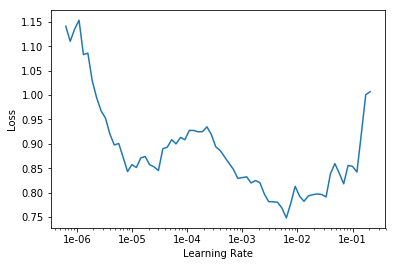

In [6]:
# find learning rate
learn.lr_find()
learn.recorder.plot()

In [7]:
lr = 1e-2

In [8]:
# Train!
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,0.706272,0.422866,0.840000
2,0.665752,0.922285,0.680000
3,0.816944,0.486709,0.720000
4,0.660047,0.634739,0.680000
5,0.519966,0.108338,0.920000


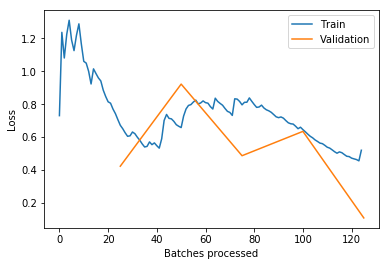

In [10]:
learn.recorder.plot_losses()

## Test 2. Adding Regularization
There seems to be some improvement **92%** accuracy with validation set (small sample size) but we also seem to be **underfitting** out data. What this means if we can train for much longer, and introduce some regularization methods such as: 
* Dropout
* Weight Decay
* Momentum

### More Epochs
The first thing we will experiment with is more epochs 

In [6]:
# Resetting/loading
arch = densenet169
learn = create_cnn(data, arch, metrics=[accuracy])

/opt/conda/envs/fastai/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [7]:
# We will be using the same lr, therefor we won't look for another learning rate as it's the same model
lr = 1e-2

In [8]:
learn.fit_one_cycle(20, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,0.858825,0.960679,0.400000
2,0.633835,0.484632,0.840000
3,0.577745,0.228885,0.840000
4,0.561730,0.402680,0.720000
5,0.595805,1.445065,0.560000
6,0.548447,1.065358,0.680000
7,0.550344,1.044967,0.760000
8,0.541805,0.212485,0.880000
9,0.594979,0.080685,1.000000
10,0.425913,0.468575,0.800000


In [9]:
learn.save('1a')

### Learning Rates
By looking at our data, we can see that our **train_loss** > **valid_loss**, though it's important to note that we have a small dataset this still indicates **underfitting** of our data.

To create a better model we can
* Increase Learning Rate 
* More Epochs 

We ran the previous model for 20 epochs, and it seems to generalize much better than running with fewer epochs, but let's not experiment with higher **learning rates**

You may have also noticed we are using ```learn.fit_one_cycle()``` which uses **one cycle learning** to learn more about this method check out this amazing blog: https://sgugger.github.io/the-1cycle-policy.html by **Sylvain Gugger**

In [21]:
arch = densenet169
learn = create_cnn(data, arch, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


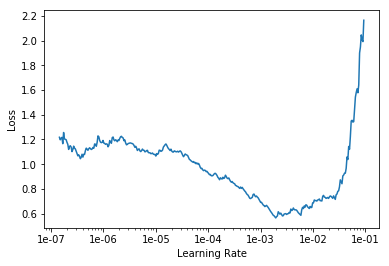

In [23]:
learn.lr_find(num_it=500)
learn.recorder.plot()

In [9]:
lr1 = 1e-1
lr2 = 1e-3
lr3 = 1e-4
lr4 = 3e-4

In [25]:
"""
lr = 1e-3 - best
"""
learn.fit_one_cycle(5, slice(lr2))

epoch,train_loss,valid_loss,accuracy
1,0.772065,0.654465,0.720000
2,0.663218,0.587141,0.720000
3,0.587327,0.431311,0.880000
4,0.487888,0.420361,0.880000
5,0.432415,0.429621,0.840000


In [29]:
"""
lr = 1e-4
"""
learn.fit_one_cycle(5, slice(lr3))

epoch,train_loss,valid_loss,accuracy
1,1.225149,0.896008,0.480000
2,1.009994,0.688809,0.480000
3,0.830655,0.590339,0.760000
4,0.726268,0.511817,0.880000
5,0.661244,0.494784,0.760000


In [31]:
"""
lr = 3e-4
"""
learn.fit_one_cycle(5, slice(lr4))

epoch,train_loss,valid_loss,accuracy
1,0.985870,0.750704,0.520000
2,0.788607,0.788345,0.640000
3,0.722258,0.628395,0.720000
4,0.642800,0.544647,0.880000
5,0.571322,0.536841,0.880000


In [33]:
"""
lr = 1e-1
"""
learn.fit_one_cycle(5, slice(lr1))

epoch,train_loss,valid_loss,accuracy
1,0.643850,1.857578,0.440000
2,0.651970,0.918120,0.680000
3,0.698976,0.584169,0.600000
4,0.543819,0.357125,0.840000
5,0.560175,0.299872,0.960000


#### Conclusion
From this small test, we can see that ```lr = 1e-3``` seems to perform the best, allowing us to generalize well. We will experiment further with more epochs with this learning rate until we cause **overfitting**

If we hit a plateau, it could indicate LR was too small and we can't get out of a **local minimum** in which case we will use the next best (higher) learning rate and continue. 

In [14]:
"""
lr = 1e-3 - best so far
epochs = 10
"""
learn.fit_one_cycle(10, slice(lr2))

epoch,train_loss,valid_loss,accuracy
1,1.005095,0.694403,0.680000
2,0.782721,0.421731,0.800000
3,0.615791,0.328758,0.920000
4,0.503598,0.392533,0.920000
5,0.419896,0.314122,0.840000
6,0.357075,0.374398,0.880000
7,0.359854,0.398423,0.840000
8,0.337707,0.375264,0.880000
9,0.346670,0.352374,0.880000
10,0.285873,0.386763,0.880000


In [16]:
"""
lr = 1e-3 - best so far
epochs = 20
"""
learn.fit_one_cycle(20, slice(lr2))

epoch,train_loss,valid_loss,accuracy
1,0.955375,0.898094,0.560000
2,0.768912,0.566579,0.720000
3,0.658524,0.438901,0.880000
4,0.583932,0.317586,0.840000
5,0.490309,0.246670,0.840000
6,0.449178,0.281276,0.880000
7,0.379020,0.236249,0.920000
8,0.346056,0.243849,0.880000
9,0.347180,0.244552,0.880000
10,0.335469,0.178639,0.960000


In [18]:
"""
lr = 1e-3 - best so far
epochs = 30
"""
learn.fit_one_cycle(30, slice(lr2))

epoch,train_loss,valid_loss,accuracy
1,1.125005,0.607510,0.640000
2,0.864862,0.377071,0.880000
3,0.804675,0.309719,0.920000
4,0.693794,0.260378,0.920000
5,0.613772,0.323806,0.840000
6,0.586432,0.291585,0.840000
7,0.504194,0.584727,0.640000
8,0.424454,0.356799,0.840000
9,0.343925,0.401303,0.800000
10,0.297997,0.476771,0.840000


In [20]:
# Trying higher learning rate
lr = 3e-3
"""
lr = 3e-3 
epochs = 30
"""
learn.fit_one_cycle(30, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,0.833261,0.941505,0.480000
2,0.908705,0.629363,0.720000
3,0.691341,0.469815,0.880000
4,0.479008,0.501714,0.720000
5,0.476815,0.242426,0.920000
6,0.468871,0.678745,0.720000
7,0.412577,0.182345,0.920000
8,0.438958,0.378370,0.840000
9,0.324432,0.356120,0.840000
10,0.286680,0.097261,0.960000


#### Conclusion
From conducting several test on different **Learning Rates** and **Epochs** we found an optimal learning rate of:
**lr = 3e-3**. We could also train more until we overfit, and then introduce **regularization**



### Regularization methods
Now we will add **regularization** to our model which will allow it to **generalize** much better:
* Weight Decay
* Momentum

To learn more about finding optimal regulatization parameters check out: https://arxiv.org/pdf/1803.09820.pdf

#### Weight Decay

In [41]:
"""
wd = weight decay, default = 0

We will be testing: [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
"""
learn = create_cnn(data, arch, metrics=[accuracy])
learn.true_wd = True # will turn on/off weight decay
learn.bn_wd = False # turns on/off | weight decay is removed from batchnorm - check paper

/opt/conda/envs/fastai/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [24]:
"""
lr = 3e-3 
wd = 1e-1
"""
lr = 3e-3
wd_ = 1e-1
learn.fit_one_cycle(5, slice(lr), wd=wd_)

epoch,train_loss,valid_loss,accuracy
1,0.732946,0.888292,0.600000
2,0.521100,0.597848,0.840000
3,0.400243,0.736838,0.800000
4,0.397618,0.518884,0.840000
5,0.394747,0.546271,0.840000


In [26]:
"""
lr = 3e-3 
wd = 1e-2
"""
lr = 3e-3
wd_ = 1e-2
learn.fit_one_cycle(5, slice(lr), wd=wd_)

epoch,train_loss,valid_loss,accuracy
1,0.871373,0.647621,0.720000
2,0.644080,0.591855,0.760000
3,0.530872,0.602606,0.680000
4,0.426593,0.499319,0.720000
5,0.365089,0.432882,0.800000


In [28]:
"""
lr = 3e-3 
wd = 1e-3
"""
lr = 3e-3
wd_ = 1e-3
learn.fit_one_cycle(5, slice(lr), wd=wd_)

epoch,train_loss,valid_loss,accuracy
1,0.773834,1.141605,0.480000
2,0.661016,0.399478,0.800000
3,0.464017,0.361821,0.840000
4,0.339644,0.392270,0.760000
5,0.252329,0.392592,0.760000


In [30]:
"""
lr = 3e-3 
wd = 1e-4
"""
lr = 3e-3
wd_ = 1e-4
learn.fit_one_cycle(5, slice(lr), wd=wd_)

epoch,train_loss,valid_loss,accuracy
1,0.779214,0.843436,0.560000
2,0.554993,0.342931,0.800000
3,0.563206,0.297062,0.840000
4,0.478322,0.227750,0.840000
5,0.445102,0.301418,0.840000


In [32]:
"""
lr = 3e-3 
wd = 1e-5
"""
lr = 3e-3
wd_ = 1e-5
learn.fit_one_cycle(5, slice(lr), wd=wd_)

epoch,train_loss,valid_loss,accuracy
1,0.830667,0.549393,0.720000
2,0.765862,0.567469,0.640000
3,0.581668,0.596404,0.760000
4,0.436076,0.541666,0.760000
5,0.362557,0.539884,0.760000


In [34]:
"""
lr = 3e-3 
wd = 1e-6
"""
lr = 3e-3
wd_ = 1e-6
learn.fit_one_cycle(5, slice(lr), wd=wd_)

epoch,train_loss,valid_loss,accuracy
1,0.889566,0.709553,0.720000
2,0.658702,0.769341,0.680000
3,0.641047,0.491862,0.800000
4,0.484667,0.393679,0.800000
5,0.410820,0.393068,0.840000


In [36]:
"""
lr = 3e-3 
wd = 0 - default
"""
lr = 3e-3
wd_ = 0.
learn.fit_one_cycle(5, slice(lr), wd=wd_)

epoch,train_loss,valid_loss,accuracy
1,0.659222,0.772920,0.440000
2,0.550963,0.693083,0.680000
3,0.503057,0.441209,0.840000
4,0.473157,0.342765,0.840000
5,0.391258,0.347247,0.800000


#### Conclusion - Weight Decay
From running quick experiments, we will stick to default **weight_decay = 0.** 

#### Momentum

In [39]:
mom_default = (0.95, 0.85)
mom_two = (0.99, 0.90)

In [40]:
learn.fit_one_cycle(5, slice(lr), moms=mom_two)

epoch,train_loss,valid_loss,accuracy
1,0.803717,0.513635,0.720000
2,0.594648,0.597346,0.760000
3,0.499816,0.617949,0.800000
4,0.462174,0.485228,0.760000
5,0.336742,0.487674,0.720000


In [42]:
learn.fit_one_cycle(5, slice(lr), moms=mom_default)

epoch,train_loss,valid_loss,accuracy
1,0.773010,0.737503,0.440000
2,0.672608,0.507828,0.680000
3,0.548311,0.393269,0.680000
4,0.438374,0.202912,0.960000
5,0.340138,0.198406,0.960000


#### Conclusion - Momentum 
default values seem to perform better

### Putting it all together
Now that we have found some fine-tuning parameters, we will train for high epochs and finally **conclude** this experiment

In [47]:
arch = densenet169
learn = create_cnn(data, arch, metrics=[accuracy])
learn.true_wd = True # will turn on/off weight decay
learn.bn_wd = False # turns on/off | weight decay is removed from batchnorm - check paper

In [44]:
"""
epochs = 10
lr = 3e-3 
wd = 0 - default
momentum = (0.95, 0.85)
"""
lr = 3e-3
wd_ = 0.
mom_default = (0.95, 0.85)
learn.fit_one_cycle(10, slice(lr), wd=wd_, moms=mom_default)

epoch,train_loss,valid_loss,accuracy
1,0.644854,0.506198,0.680000
2,0.636060,0.575071,0.800000
3,0.484265,0.259463,0.880000
4,0.440915,0.374355,0.760000
5,0.387308,0.200040,0.920000
6,0.324058,0.227405,0.920000
7,0.311372,0.195801,0.960000
8,0.271284,0.221788,0.880000
9,0.227070,0.163256,0.960000
10,0.269465,0.142143,0.960000


In [48]:
"""
epochs = 30
lr = 3e-3 
wd = 0 - default
momentum = (0.95, 0.85)
"""
lr = 3e-3
wd_ = 0.
mom_default = (0.95, 0.85)
learn.fit_one_cycle(20, slice(lr), wd=wd_, moms=mom_default)

epoch,train_loss,valid_loss,accuracy
1,0.767849,0.574598,0.560000
2,0.695924,0.604083,0.720000
3,0.529201,0.233038,0.920000
4,0.389562,0.149599,0.920000
5,0.370007,0.220382,0.880000
6,0.439538,0.908027,0.720000
7,0.442284,0.126522,0.960000
8,0.367921,0.316231,0.800000
9,0.389047,0.524047,0.720000
10,0.387420,0.242080,0.880000


## Conclusions
From our initial experiment we are able to prove that popular music does indeed contain unique characteristics, that which our CNN can extract and learn to predict. 

For this initial experiment we only used a **Pre-Trained DenseNet169** architecture. 

In the future we will:
* Have a much larger dataset
* Segment datasets, by genre
* Experiment with various architectures

and finally test in **inference**